In [1]:
import random
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display
import xgboost as xgb
import os.path
import shutil
import warnings
from sklearn.svm import SVC 
from os import listdir
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, make_scorer, precision_score, f1_score, roc_auc_score
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pyAudioAnalysis.audioTrainTest import extract_features_and_train

# Global Variables

In [3]:
COUGHVID_DATASET_PATH = "E:\\Dataset\\COUGHVID-Dataset\\public_dataset\\"
COUGHVID_ATS_NPY_PATH = COUGHVID_DATASET_PATH + "npy_array\\"
COUGHVID_CSV_PATH = "E:\\Dataset\\COUGHVID-Dataset\\public_dataset\\metadata_compiled.csv"
COSWARA_DATASET_PATH = "E:\\Dataset\\COVID19-Coswara-Data\\"
COSWARA_ATS_NPY_PATH = COSWARA_DATASET_PATH + "Extracted_data\\npy_array\\"
VIRUFY_DATASET_PATH = "E:\\Dataset\\VIRUFY-Dataset\\"

COUGH_DETECTED_THRESHOLD = 0.9
SAMPLE_RATE = 16000
RANDOM_SEED = 23520043

plt.rcParams['figure.figsize'] = (15,6)

# ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preprocessing

In [4]:
def extract_ats_and_label_from_dataframe(df, path, column_name_id='id', column_name_label='label', max_frame_len=None):
    # df where audio id and label are located
    # path where each audio file located 

    ats = []
    label = []
    list_filename = []

    for idx, row in df.iterrows():
        filename = row[column_name_id] + '.npy'
        if os.path.exists(path + filename):
            audio_file = np.load(path + filename)

            if max_frame_len == None:
                # only add non empty audio_file
                if len(audio_file) > 0:
                    ats.append(audio_file)
                    label.append(row[column_name_label])
                    list_filename.append(row[column_name_id])
            else:
                # only add non empty audio_file and below max_frame_len
                if len(audio_file) > 0 and len(audio_file) <= (max_frame_len * SAMPLE_RATE):
                    ats.append(audio_file)
                    label.append(row[column_name_label])
                    list_filename.append(row[column_name_id])


    return ats, label, list_filename

def get_ats_and_label(df, path, dataset_name, column_name_id='id', column_name_label='label', max_frame_len=None):
    # path is ats path
    # example: COSWARA_ATS_NPY_PATH
    
    ats_path = path + 'ats_' + dataset_name.lower() + '.npy'
    label_path = path + 'label_' + dataset_name.lower() + '.npy'
    
    # check if files are available
    if os.path.isfile(ats_path) and os.path.isfile(label_path):
        print('Files founded, loading...')
        # load existing ats file and label
        ats = np.load(ats_path) 
        label = np.load(label_path) 

    else:
        print('Files not found, extracting...')
        # ats and label are not available yet
        # extract first
        ats, label, _ = extract_ats_and_label_from_dataframe(df, path, column_name_id, column_name_label, max_frame_len)   

        print('\nSaving files...')
        # saving ats file
        print('Saving ats file at: ' + ats_path)
        save_npy(np.asarray(ats), ats_path)
        print('Saving label file at: ' + label_path)
        save_npy(np.asarray(label), label_path)
        
    return np.asarray(ats), np.asarray(label)

# saving numpy array 
def save_npy(npy, path):
    if os.path.isfile(path):
        print("Existing File Found: " + path)
        pass
    else:
        np.save(path, npy)
        

## Coswara
### Reading CSV File & Preprocessing

In [5]:
# read csv file
df_coswara = pd.read_csv(COSWARA_DATASET_PATH + 'combined_data.csv')

# take only necessary values
df_coswara = df_coswara[['id', 'covid_status']]

# making id_cough-heavy & id_cough-shallow
temp = df_coswara.copy()
temp['id'] = temp['id'] + '_cough-heavy'
df_coswara['id'] = df_coswara['id'] + '_cough-shallow'

# concat df id_cough-heavy & id_cough-shallow
df_coswara = pd.concat([df_coswara, temp])
df_coswara = df_coswara.sort_index().reset_index(drop=True)

# delete df
del temp

In [6]:
df_coswara = df_coswara.drop(df_coswara[df_coswara['covid_status'] == 'no_resp_illness_exposed'].index)
df_coswara = df_coswara.drop(df_coswara[df_coswara['covid_status'] == 'resp_illness_not_identified'].index)

df_coswara['label'] = df_coswara['covid_status']

pd.options.mode.chained_assignment = None  # default='warn'

for idx, row in df_coswara.iterrows():
    if row['covid_status'] == 'healthy':
        df_coswara['label'][idx] = 0
    elif row['covid_status'] == 'positive_mild':
        df_coswara['label'][idx] = 1
    elif row['covid_status'] == 'positive_asymp':
        df_coswara['label'][idx] = 1
    elif row['covid_status'] == 'positive_moderate':
        df_coswara['label'][idx] = 1
    elif row['covid_status'] == 'recovered_full':
        df_coswara['label'][idx] = 0
        
df_coswara = df_coswara[['id', 'label']]

### Reading Audio Files
Reading audio files, downsampling to SAMPLE_RATE, save the .npy

In [7]:
path = COSWARA_DATASET_PATH + "Extracted_data\\"

count = 0
for u in df_coswara['id']:
    if count % 50 == 0:
        print(count)
    if os.path.isfile(COSWARA_ATS_NPY_PATH + u + '.npy'):
        pass
    else:
        try:
            y, _ = librosa.load(path + u + ".wav", sr=SAMPLE_RATE)
            np.save(COSWARA_ATS_NPY_PATH + u , np.array(y))
        except FileNotFoundError:
            print("File Not Found: " + path + u)
        except ValueError:
            print("File is too short: " + path + u)

    count = count + 1

0
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\C3luMlCgAFZqGmGjFscXe9fVHSG3_cough-heavy
50
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\pBBuvcoBj7hjmNVYFICT4hQYRGw1_cough-heavy
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\pBBuvcoBj7hjmNVYFICT4hQYRGw1_cough-shallow
100
150
200
250
300
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\CdU4pgCdFcZxtDHTpLUn1mO9J3o2_cough-shallow
350
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\9z2XQAVyIkb0saZVigWBr3MsDcr1_cough-shallow
400
450
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\aU8pLZV1OUQJV0GKeeIlgWhYWeA2_cough-shallow
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\jSb7SyucSmTHhzs3qQoBExRMQZ02_cough-shallow
1350
File is too short: E:\Dataset\COVID19-Coswara-Data\Extracted_data\f9g4olEAspen4dJakQJsI2EME032_cough-heavy
1400
1450
1500
15

### Getting Audio and its Corresponding Label
Load .npy audio time series to get audio and its corresponding label

In [8]:
_, _, list_filename_coswara = extract_ats_and_label_from_dataframe(df_coswara, COSWARA_ATS_NPY_PATH)

In [10]:
import pickle
path = COSWARA_ATS_NPY_PATH
filename = 'filename_coswara'
pickle.dump(list_filename_coswara, open(path + filename, 'wb'))

In [11]:
ats_coswara, label_coswara = get_ats_and_label(df_coswara, COSWARA_ATS_NPY_PATH, dataset_name='coswara')
# ats_coswara, label_coswara = get_ats_and_label(df_coswara, COSWARA_ATS_NPY_PATH, dataset_name='coswara_under_16.59', max_frame_len=16.59)

Files founded, loading...


In [12]:
Counter(label_coswara)

Counter({0: 2391, 1: 216})

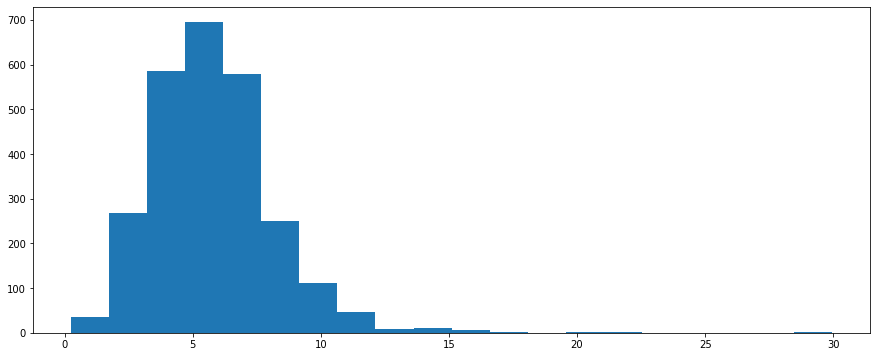

In [13]:
frame_len = []
for elem in ats_coswara:
    frame_len.append(elem.shape[0] / SAMPLE_RATE)
    
frame_len = np.asarray(frame_len)
# a = np.histogram(frame_len)
a = plt.hist(frame_len, bins=20)
# plt.show()

In [14]:
for i in range(len(a[0])):
    print(str(round(a[1][i], 2)) + ' - ' + str(round(a[1][i+1], 2)) + ': '+ str(a[0][i]))

0.26 - 1.74: 35.0
1.74 - 3.23: 269.0
3.23 - 4.71: 586.0
4.71 - 6.2: 695.0
6.2 - 7.68: 580.0
7.68 - 9.16: 251.0
9.16 - 10.65: 112.0
10.65 - 12.13: 47.0
12.13 - 13.62: 9.0
13.62 - 15.1: 10.0
15.1 - 16.59: 7.0
16.59 - 18.07: 2.0
18.07 - 19.56: 0.0
19.56 - 21.04: 1.0
21.04 - 22.53: 1.0
22.53 - 24.01: 0.0
24.01 - 25.5: 0.0
25.5 - 26.98: 0.0
26.98 - 28.47: 0.0
28.47 - 29.95: 2.0


## Coughvid
### Reading CSV File & Preprocessing

In [15]:
df_coughvid = pd.read_csv(COUGHVID_CSV_PATH)

# dropping na values in status column
df_coughvid = df_coughvid[df_coughvid['status'].notna()]

# excluding symptomatic cases
df_coughvid = df_coughvid[df_coughvid['status'] != 'symptomatic']

# filtered only cough_detected > threshold
df_coughvid = df_coughvid[df_coughvid['cough_detected'] > COUGH_DETECTED_THRESHOLD]

# removing unnecessary columns
df_coughvid = df_coughvid[['uuid', 'cough_detected', 'status']]

# converting labels
df_coughvid['label'] = np.where((df_coughvid.status == 'healthy'), 0, 1)

# drop columns
df_coughvid = df_coughvid.drop(columns='status')
df_coughvid = df_coughvid.drop(columns='cough_detected')

# rename uuid to id
df_coughvid = df_coughvid.rename(columns={'uuid': 'id'})

df_coughvid.head()

,id,label
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,0
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0
8,00291cce-36a0-4a29-9e2d-c1d96ca17242,0
10,002d28bc-7806-4dfb-9c9b-afa8cb623cac,0


### Reading Audio Files
Reading audio files, downsampling to SAMPLE_RATE, save the .npy

In [16]:
count = 0
for u in df_coughvid['id']:
    if count % 50 == 0:
        print(count)
    if os.path.isfile(COUGHVID_ATS_NPY_PATH + u + '.npy'):
        pass
    else:
        try:
            y, _ = librosa.load(COUGHVID_DATASET_PATH + u + ".ogg", sr=SAMPLE_RATE)
        except FileNotFoundError:
            y, _ = librosa.load(COUGHVID_DATASET_PATH + u + ".webm", sr=SAMPLE_RATE)
    
        np.save(COUGHVID_ATS_NPY_PATH + u , np.array(y))

    count = count + 1

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100


### Getting Audio and its Corresponding Label
Load .npy audio time series to get audio and its corresponding label

In [26]:
ats_coughvid, label_coughvid = get_ats_and_label(df_coughvid, COUGHVID_ATS_NPY_PATH, dataset_name='coughvid')
# ats_coughvid, label_coughvid = get_ats_and_label(df_coughvid, COUGHVID_ATS_NPY_PATH, dataset_name='coughvid_under_10.28', max_frame_len=10.28)

Files founded, loading...


In [27]:
_, _, list_filename_coughvid = extract_ats_and_label_from_dataframe(df_coughvid, COUGHVID_ATS_NPY_PATH)

In [30]:
import pickle
path = COUGHVID_ATS_NPY_PATH
filename = 'filename_coughvid'
pickle.dump(list_filename_coughvid, open(path + filename, 'wb'))

In [32]:
len(pickle.load(open(path + filename, 'rb')))

5139

In [14]:
Counter(label_coughvid)
len(label_coughvid)

5120

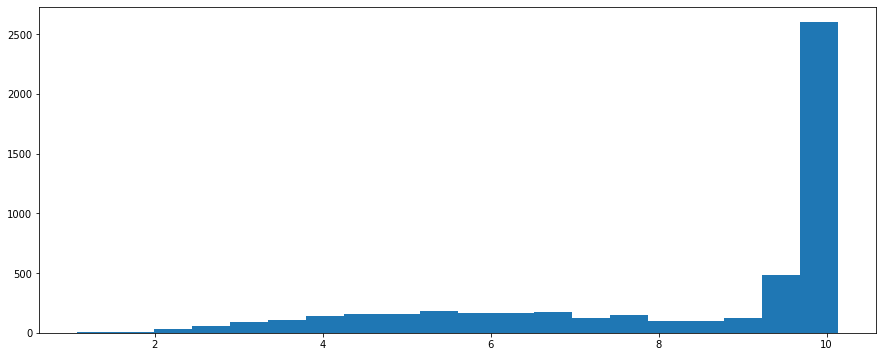

In [672]:
frame_len = []
for elem in ats_coughvid:
    frame_len.append(elem.shape[0] / SAMPLE_RATE)
    
frame_len = np.asarray(frame_len)
# a = np.histogram(frame_len)
a = plt.hist(frame_len, bins=20)
plt.show()

In [673]:
for i in range(len(a[0])):
    print(str(round(a[1][i], 2)) + ' - ' + str(round(a[1][i+1], 2)) + ': '+ str(a[0][i]))

1.08 - 1.53: 5.0
1.53 - 1.99: 10.0
1.99 - 2.44: 35.0
2.44 - 2.89: 56.0
2.89 - 3.34: 89.0
3.34 - 3.8: 109.0
3.8 - 4.25: 142.0
4.25 - 4.7: 158.0
4.7 - 5.16: 157.0
5.16 - 5.61: 179.0
5.61 - 6.06: 166.0
6.06 - 6.52: 169.0
6.52 - 6.97: 173.0
6.97 - 7.42: 126.0
7.42 - 7.88: 145.0
7.88 - 8.33: 102.0
8.33 - 8.78: 98.0
8.78 - 9.23: 122.0
9.23 - 9.69: 480.0
9.69 - 10.14: 2599.0


# Feature Extraction

In [118]:
def audio_to_mfcc(ats, sr, n_mfcc=13):
    mfcc = []
    for y in ats:
        mfcc_0 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc_0)
        mfcc_delta2 = librosa.feature.delta(mfcc_0, order=2)
        mfcc.append(np.concatenate((mfcc_0, mfcc_delta,mfcc_delta2)))
    
    return mfcc

def pad_mfcc(mfccs, n_frame=None):
    if n_frame == None:
        max_frame = 0
        for mfcc in mfccs:
            if mfcc.shape[1] > max_frame:
                max_frame = mfcc.shape[1]
        
        n_frame = max_frame
        
    padded_mfccs = []
    for mfcc in mfccs:
        padded_mfccs.append(librosa.util.pad_center(mfcc, n_frame, axis=1))
    
    return np.asarray(padded_mfccs)

def get_stats_feats_mfcc(mfccs):
    stats_feats_mfcc = []
    for mfcc in mfccs:
        ft1 = mfcc
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        stats_feats_mfcc.append(ft1_trunc)

    return np.asarray(stats_feats_mfcc)

def get_stats_feats_nmf(nmfs):
    stats_feats_nmf = []
    for nmf in nmfs:
        ft1 = nmf.T
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        stats_feats_nmf.append(ft1_trunc)

    return np.asarray(stats_feats_nmf)

def flatten_mfcc(mfccs):
    return np.asarray([mfcc.flatten() for mfcc in mfccs])

@ignore_warnings(category=ConvergenceWarning)
def audio_to_nmf_spectrogram(ats, n_components=40):
    nmf_spectrogram = []
    
    for y in ats:
        each_nmf_spectrogram = each_audio_to_nmf_spectrogram(y, n_components)
        nmf_spectrogram.append(each_nmf_spectrogram)
        
    return np.asarray(nmf_spectrogram)

@ignore_warnings(category=ConvergenceWarning)
def each_audio_to_nmf_spectrogram(y, n_components=40):
    S = np.abs(librosa.stft(y))
        
    # comps (without temporal information)
    # acts (with temporal information)
    comps, acts = librosa.decompose.decompose(S, n_components=n_components)
    return comps
    
    # sbvs.shape (1025, n_components)
    # calculate spectrogram on each ats using stft
    # spectrogram (1025, n_frames)         
    spectrogram = np.abs(librosa.stft(y))
    spectrogram = ((1.0 / 2048) * ((spectrogram) ** 2))
       
    # calculate filter_banks
    filter_banks = np.dot(sbvs.T, spectrogram)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    # nmf_mfcc.shape (n_components, n_frames)
    each_nmf_mfcc = librosa.feature.mfcc(S=filter_banks, sr=sr, n_mfcc=n_mfcc)

    return each_nmf_mfcc
def each_audio_to_nmf_mfcc(y, sbvs, n_mfcc=13, sr=SAMPLE_RATE):
    # sbvs.shape (1025, n_components)
    # calculate spectrogram on each ats using stft
    # spectrogram (1025, n_frames)         
    spectrogram = np.abs(librosa.stft(y))
    spectrogram = ((1.0 / 2048) * ((spectrogram) ** 2))
    
#     print(type(spectrogram[0][0]))
#     print(type(sbvs[0][0]))
    
    # calculate filter_banks
    filter_banks = np.dot(sbvs.T, spectrogram)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    # nmf_mfcc.shape (n_components, n_frames)
    each_nmf_mfcc = librosa.feature.mfcc(S=filter_banks, sr=sr, n_mfcc=n_mfcc)

    return each_nmf_mfcc

def audio_to_nmf_mfcc(ats, sbvs, n_mfcc=13, sr=SAMPLE_RATE):
    nmf_mfcc = []
    
    for y in ats:
        each_nmf_mfcc = each_audio_to_nmf_mfcc(y, sbvs, n_mfcc, sr)
        nmf_mfcc_delta = librosa.feature.delta(each_nmf_mfcc)
        nmf_mfcc_delta2 = librosa.feature.delta(each_nmf_mfcc, order=2)
        nmf_mfcc.append(np.concatenate((each_nmf_mfcc, nmf_mfcc_delta, nmf_mfcc_delta2)))
        
    return nmf_mfcc

def select_and_concat_audio(ats, n_audio=10):
    random.seed(RANDOM_SEED)
    selected_audio = random.sample(list(ats), n_audio)
    
    return np.concatenate(selected_audio)

def audio_to_logmelspectrogram(ats):
    lms = []
    for y in ats:
        S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE)
        S = librosa.power_to_db(S)
        lms.append(S)
    
    return lms

## Coswara

### MFCC

In [31]:
mfcc_coswara = audio_to_mfcc(ats_coswara, sr=SAMPLE_RATE)
mfcc_stats_coswara = get_stats_feats_mfcc(mfcc_coswara)
mfcc_padded_coswara = flatten_mfcc(pad_mfcc(mfcc_coswara))

### NMF-Spectrogram

In [135]:
nmf_spectrogram_coswara = np.load(COSWARA_ATS_NPY_PATH + 'nmf_spectrogram_coswara.npy')
nmf_spectrogram_stats_coswara = np.load(COSWARA_ATS_NPY_PATH + 'nmf_spectrogram_stats_coswara.npy')

In [86]:
nmf_spectrogram_coswara = audio_to_nmf_spectrogram(ats_coswara, n_components)

# getting stats of nmf_spectrogram
nmf_spectrogram_stats_coswara = get_stats_feats_nmf(nmf_spectrogram_coswara)

### NMF-MFCC

In [116]:
n_audio = int(0.05 * len(ats_coswara))
concatenated_audio = select_and_concat_audio(ats_coswara[train_idx_coswara], n_audio=n_audio)
fbank_nmf_coswara = each_audio_to_nmf_spectrogram(concatenated_audio, n_components=40)

In [120]:
nmf_mfcc_coswara = audio_to_nmf_mfcc(ats_coswara, sbvs=fbank_nmf_coswara)
nmf_mfcc_stats_coswara = get_stats_feats_mfcc(nmf_mfcc_coswara)

### Logmelspectrogram

In [98]:
lms_coswara = audio_to_logmelspectrogram(ats_coswara)
lms_stats_coswara = get_stats_feats_mfcc(lms_coswara)

In [99]:
# save_npy(lms_coswara, path=COSWARA_ATS_NPY_PATH + 'lms_coswara.npy')
save_npy(lms_stats_coswara, path=COSWARA_ATS_NPY_PATH + 'lms_stats_coswara.npy')

### Visualize Features

In [150]:
i = 0
for f, l in zip(list_filename_coswara, label_coswara):
    if l == 1:
        print(i)
    i += 1



41
42
43
44
45
46
47
48
53
54
57
58
65
66
67
68
85
86
213
214
215
216
223
224
227
228
231
232
233
234
237
238
241
242
243
244
245
246
247
248
251
252
257
258
259
260
261
262
263
264
265
266
269
270
273
274
275
276
279
280
285
286
289
290
295
296
297
298
301
302
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
329
330
336
337
342
343
348
349
356
357
358
359
374
375
378
379
389
390
391
392
399
400
411
412
415
416
419
420
425
426
427
428
429
430
431
432
433
434
447
448
449
450
451
452
460
461
464
465
466
467
472
473
474
475
476
477
480
481
482
483
488
489
490
491
496
497
498
499
500
501
508
509
514
515
518
519
520
521
522
523
526
527
528
529
916
917
982
983
998
999
1018
1019
1032
1033
1034
1035
1036
1037
1044
1045
1046
1047
1050
1051
1052
1053
1062
1063
1120
1121
1130
1131
1152
1153
2263
2264
2385
2386
2387
2388
2417
2418
2561
2562
2581
2582


DRBAZX64nuVtqBQf13gH7r36Mh52_cough-heavy
0


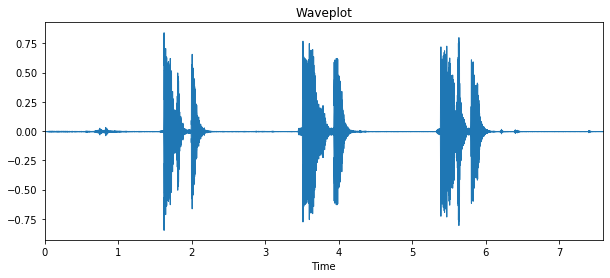

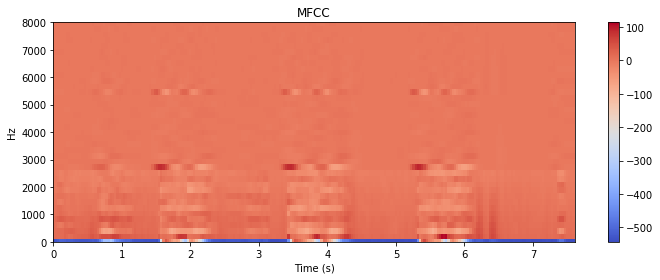

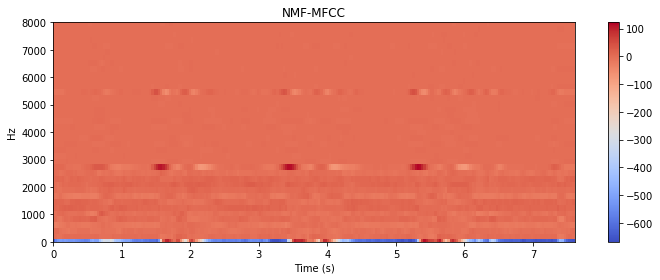

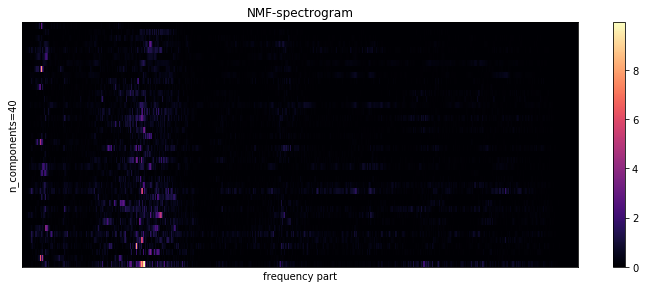

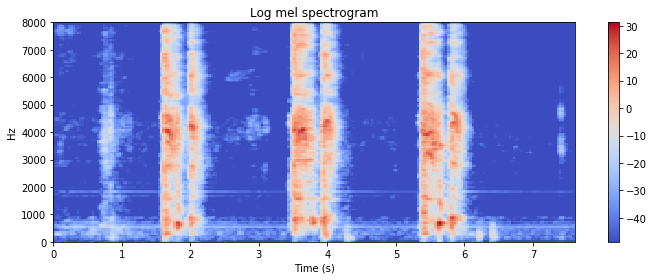

In [165]:
idx = 1
print(list_filename_coswara[idx])
print(label_coswara[idx])

# Waveplot Visualization
data = ats_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.waveplot(data, sr=SAMPLE_RATE)
plt.title('Waveplot')
plt.show()

# MFCC Visualization
data = mfcc_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis='s', y_axis='linear', sr=SAMPLE_RATE)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# NMF-MFCC Visualization
data = nmf_mfcc_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis='s', y_axis='linear', sr=SAMPLE_RATE)
plt.colorbar()
plt.title('NMF-MFCC')
plt.tight_layout()
plt.show()

# NMF-spectrogram Visualization
data = nmf_spectrogram_coswara[idx].T
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis=None, y_axis=None, sr=SAMPLE_RATE)
plt.colorbar()
plt.title('NMF-spectrogram')
plt.tight_layout()
plt.ylabel('n_components=40')
plt.xlabel('frequency part')
plt.show()

# Logmelspectrogram Visualization
data = lms_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis='s', y_axis='linear', sr=SAMPLE_RATE)
plt.colorbar()
plt.title('Log mel spectrogram')
plt.tight_layout()
plt.show()

y0TkG5sfyhadW3VSct50RTl3HN02_cough-heavy
1


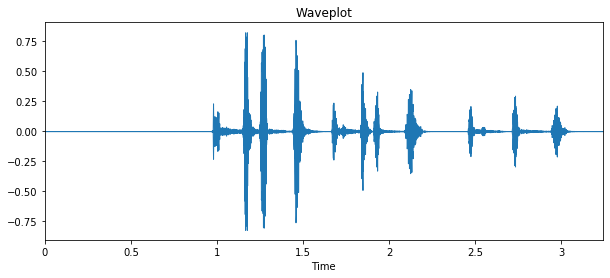

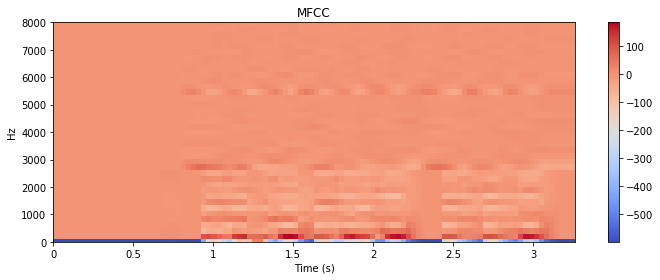

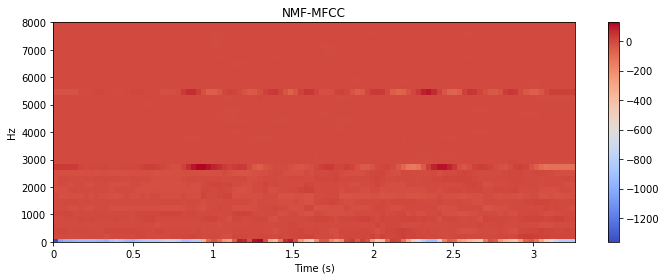

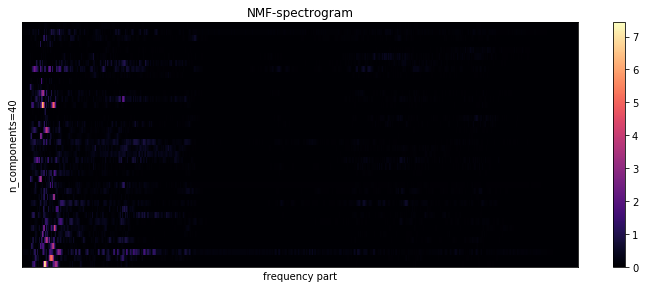

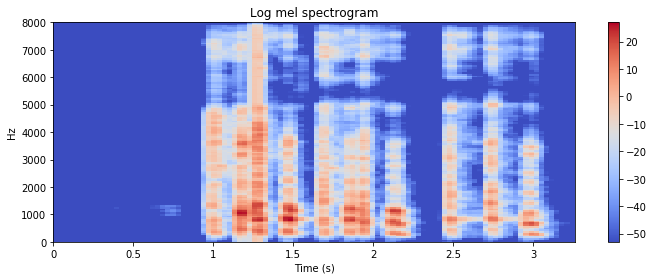

In [164]:
idx = 42
print(list_filename_coswara[idx])
print(label_coswara[idx])

# Waveplot Visualization
data = ats_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.waveplot(data, sr=SAMPLE_RATE)
plt.title('Waveplot')
plt.show()

# MFCC Visualization
data = mfcc_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis='s', y_axis='linear', sr=SAMPLE_RATE)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# NMF-MFCC Visualization
data = nmf_mfcc_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis='s', y_axis='linear', sr=SAMPLE_RATE)
plt.colorbar()
plt.title('NMF-MFCC')
plt.tight_layout()
plt.show()

# NMF-spectrogram Visualization
data = nmf_spectrogram_coswara[idx].T
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis=None, y_axis=None, sr=SAMPLE_RATE)
plt.colorbar()
plt.title('NMF-spectrogram')
plt.tight_layout()
plt.ylabel('n_components=40')
plt.xlabel('frequency part')
plt.show()

# Logmelspectrogram Visualization
data = lms_coswara[idx]
plt.figure(figsize=(10, 4))
librosa.display.specshow(data, x_axis='s', y_axis='linear', sr=SAMPLE_RATE)
plt.colorbar()
plt.title('Log mel spectrogram')
plt.tight_layout()
plt.show()

In [168]:
IPython.display.Audio(ats_coswara[42], rate=SAMPLE_RATE)

In [142]:
nmf_spectrogram_coswara[0].T.shape

(40, 1025)

## Coughvid

### MFCC

In [681]:
mfcc_coughvid = audio_to_mfcc(ats_coughvid, sr=SAMPLE_RATE)
mfcc_stats_coughvid = get_stats_feats_mfcc(mfcc_coughvid)
mfcc_padded_coughvid = flatten_mfcc(pad_mfcc(mfcc_coughvid))

In [682]:
mfcc_padded_coughvid.shape

(5120, 12363)

### NMF-Spectrogram

In [489]:
nmf_spectrogram_coughvid = audio_to_nmf_spectrogram(ats_coughvid, n_components=40)

In [490]:
shape = nmf_spectrogram_coughvid.shape[0:2]
nmf_spectrogram_coughvid = nmf_spectrogram_coughvid.reshape(shape)

### NMF-MFCC

In [495]:
n_audio = int(0.05 * len(ats_coughvid))
concatenated_audio = select_and_concat_audio(ats_coughvid[train_idx_coughvid], n_audio=n_audio)
fbank_nmf_coughvid = each_audio_to_nmf_spectrogram(concatenated_audio)

In [496]:
nmf_mfcc_coughvid = audio_to_nmf_mfcc(ats_coughvid, sbvs=fbank_nmf_coughvid)
nmf_mfcc_stats_coughvid = get_stats_feats_mfcc(nmf_mfcc_coughvid)

# Data Splitting

In [111]:
def get_train_test_indices(y, test_size):
# given y, split train and test and return the indices
# y is array containing labels

    n_samples = len(y)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_SEED)

    for train_idx, test_idx in sss.split(X=np.zeros(n_samples), y=y):
        continue
        
    return train_idx, test_idx

def split_train_test(data, train_idx, test_idx):
# split train test given indices
    data_train = data[train_idx]
    data_test = data[test_idx]
    
    return data_train, data_test

## Coswara

### Get Train-Test Indices

In [112]:
train_idx_coswara, test_idx_coswara = get_train_test_indices(label_coswara, 0.1)

### Get Train-Test Data

In [113]:
# split labels
y_coswara_train, \
y_coswara_test = split_train_test(label_coswara, train_idx_coswara, test_idx_coswara)

In [114]:
Counter(y_coswara_test)

Counter({1: 22, 0: 239})

In [115]:
# split mfcc stats
mfcc_stats_coswara_train, \
mfcc_stats_coswara_test = split_train_test(mfcc_stats_coswara, train_idx_coswara, test_idx_coswara)

In [88]:
# split nmf spectrogram
nmf_spectrogram_stats_coswara_train, \
nmf_spectrogram_stats_coswara_test = split_train_test(nmf_spectrogram_stats_coswara, train_idx_coswara, test_idx_coswara)

In [497]:
# split nmf mfcc stats
nmf_mfcc_stats_coswara_train, \
nmf_mfcc_stats_coswara_test = split_train_test(nmf_mfcc_stats_coswara, train_idx_coswara, test_idx_coswara)

In [707]:
mfcc_padded_coswara_train, \
mfcc_padded_coswara_test = split_train_test(mfcc_padded_coswara, train_idx_coswara, test_idx_coswara)

In [685]:
print('Train Set')
counter = Counter(y_coswara_train)
print(counter)
print(len(mfcc_stats_coswara_train))
print('\nTest Set')
counter = Counter(y_coswara_test)
print(counter)
print(len(mfcc_stats_coswara_test))

Train Set
Counter({0: 2152, 1: 194})
2346

Test Set
Counter({0: 239, 1: 22})
261


## Coughvid

### Get Train-Test Indices

In [25]:
train_idx_coughvid, test_idx_coughvid = get_train_test_indices(label_coughvid, 0.1)

### Get Train-Test Data

In [26]:
# split labels
y_coughvid_train, \
y_coughvid_test = split_train_test(label_coughvid, train_idx_coughvid, test_idx_coughvid)

In [28]:
Counter(y_coughvid_test)

Counter({0: 468, 1: 44})

In [71]:
# split mfcc stats
mfcc_stats_coughvid_train, \
mfcc_stats_coughvid_test = split_train_test(mfcc_stats_coughvid, train_idx_coughvid, test_idx_coughvid)

In [494]:
# split nmf spectrogram
nmf_spectrogram_coughvid_train, \
nmf_spectrogram_coughvid_test = split_train_test(nmf_spectrogram_coughvid, train_idx_coughvid, test_idx_coughvid)

In [498]:
# split nmf mfcc stats
nmf_mfcc_stats_coughvid_train, \
nmf_mfcc_stats_coughvid_test = split_train_test(nmf_mfcc_stats_coughvid, train_idx_coughvid, test_idx_coughvid)

In [711]:
# split mfcc pad
mfcc_padded_coughvid_train, \
mfcc_padded_coughvid_test = split_train_test(mfcc_padded_coughvid, train_idx_coughvid, test_idx_coughvid)

In [72]:
print('Train Set')
counter = Counter(y_coughvid_train)
print(counter)
print(len(mfcc_stats_coughvid_train))
print('\nTest Set')
counter = Counter(y_coughvid_test)
print(counter)
print(len(mfcc_stats_coughvid_test))

Train Set
Counter({0: 4228, 1: 397})
4625

Test Set
Counter({0: 470, 1: 44})
514


# Modelling
Choos the dataset

In [90]:
DATASET = 'coswara' # ['coughvid', 'coswara']
FEATURE = 'nmf-spectrogram-stats' # ['mfcc-stats', 'nmf-spectrogram-stats', 'nmf-mfcc-stats', 'mfcc-padded']

if DATASET == 'coswara':
    y = y_coswara_train
    y_test = y_coswara_test
    
    if FEATURE == 'mfcc-stats':
        X = mfcc_stats_coswara_train
        X_test = mfcc_stats_coswara_test
    elif FEATURE == 'nmf-spectrogram-stats':
        X = nmf_spectrogram_stats_coswara_train
        X_test = nmf_spectrogram_stats_coswara_test 
    elif FEATURE == 'nmf-mfcc-stats':
        X = nmf_mfcc_stats_coswara_train
        X_test = nmf_mfcc_stats_coswara_test
    elif FEATURE == 'mfcc-padded':
        X = mfcc_padded_coswara_train
        X_test = mfcc_padded_coswara_test
    
elif DATASET == 'coughvid':
    y = y_coughvid_train
    y_test = y_coughvid_test
    
    if FEATURE == 'mfcc-stats':
        X = mfcc_stats_coughvid_train
        X_test = mfcc_stats_coughvid_test
    elif FEATURE == 'nmf-spectrogram':
        X = nmf_spectrogram_coughvid_train
        X_test = nmf_spectrogram_coughvid_test
    elif FEATURE == 'nmf-mfcc-stats':
        X = nmf_mfcc_stats_coughvid_train
        X_test = nmf_mfcc_stats_coughvid_test
    elif FEATURE == 'mfcc-padded':
        X = mfcc_padded_coughvid_train
        X_test = mfcc_padded_coughvid_test
    
scoring = {'precision': make_scorer(precision_score, average='binary'),
            'recall': make_scorer(recall_score, average='binary'),
            'specificity':make_scorer(recall_score, average='binary', pos_label=0),
            'f1': make_scorer(f1_score, average='binary'),
            'accuracy': make_scorer(accuracy_score),
            'roc_auc': make_scorer(roc_auc_score)}

In [44]:
def print_result(exp_name, model, X_test, y_test):
    # predict
    pred = model.predict(np.asarray(X_test))
    
    # calculate scores
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    specificity = recall_score(y_test, pred, pos_label=0)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    data_result = {'exp_name': [exp_name], 
                    'accuracy': [accuracy],
                    'precision': [precision],
                    'recall': [recall],
                    'specificity': [specificity],
                    'f1': [f1],
                    'roc_auc': [roc_auc]}
    
    result = pd.DataFrame(data=data_result).set_index('exp_name')
    
    return result

## KNN

In [94]:
parameters = {'n_neighbors': [3,5], 'p':[1,2]}
new_params = {'kneighborsclassifier__' + key: parameters[key] for key in parameters}
knn = KNeighborsClassifier()

### Downsampled

In [95]:
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=RANDOM_SEED), knn)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(X, y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

,rank_test_recall,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1,mean_test_roc_auc
1,1,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.566469,0.094176,0.490148,0.573385,0.157778,0.531767
0,2,"{'kneighborsclassifier__n_neighbors': 3, 'knei...",0.549425,0.089534,0.484750,0.555270,0.151056,0.520010
3,3,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.565624,0.092098,0.479757,0.573384,0.154398,0.526570
2,4,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.577983,0.091965,0.458974,0.588728,0.153020,0.523851


In [96]:
print_result('knn-downsampled', grid_imba, X_test, y_test)

,accuracy,precision,recall,specificity,f1,roc_auc
exp_name,,,,,,
knn-downsampled,0.455939,0.052239,0.318182,0.468619,0.089744,0.393401


In [778]:
print('Best Classifier:')
print(grid_imba.best_params_)

Best Classifier:
{'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 2}


### Upsampled

In [779]:
imba_pipeline = make_pipeline(RandomOverSampler(random_state=RANDOM_SEED), knn)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(X, y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

KeyboardInterrupt: 

In [ ]:
print_result('knn-upsampled', grid_imba, X_test, y_test)

In [ ]:
print('Best Classifier:')
print(grid_imba.best_params_)

### SMOTE

In [ ]:
imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_SEED), knn)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(X, y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

In [ ]:
print_result('knn-smote', grid_imba, X_test, y_test)

In [ ]:
print('Best Classifier:')
print(grid_imba.best_params_)

## SVM

In [91]:
parameters = {'C':[1,2,3]}
new_params = {'svc__' + key: parameters[key] for key in parameters}

svc = SVC(random_state=RANDOM_SEED, gamma='auto')

### Downsampled

In [92]:
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=RANDOM_SEED), svc)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(X, y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

,rank_test_recall,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1,mean_test_roc_auc
0,1,{'svc__C': 1},0.549018,0.102907,0.577463,0.546481,0.174623,0.561972
1,2,{'svc__C': 2},0.518331,0.095830,0.572470,0.513498,0.164108,0.542984
2,3,{'svc__C': 3},0.510234,0.092795,0.562213,0.505588,0.159270,0.533901


In [93]:
print_result('svm-downsampled', grid_imba, X_test, y_test)

,accuracy,precision,recall,specificity,f1,roc_auc
exp_name,,,,,,
svm-downsampled,0.605364,0.106796,0.5,0.615063,0.176,0.557531


In [55]:
print('Best Classifier:')
print(grid_imba.best_params_)

Best Classifier:
{'svc__C': 1}


### Upsampled

In [729]:
imba_pipeline = make_pipeline(RandomOverSampler(random_state=RANDOM_SEED), svc)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(X, y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

KeyboardInterrupt: 

In [ ]:
print_result('svm-upsampled', grid_imba, X_test, y_test)

In [ ]:
print('Best Classifier:')
print(grid_imba.best_params_)

### SMOTE

In [ ]:
imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_SEED), svc)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(X, y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

In [ ]:
print_result('svm-smote', grid_imba, X_test, y_test)

In [ ]:
print('Best Classifier:')
print(grid_imba.best_params_)

## XGBoost

In [73]:
parameters = {'n_estimators':[10,20,50], 'max_depth':[2,5,10]}
new_params = {'xgbclassifier__' + key: parameters[key] for key in parameters}

model_xgb = XGBClassifier(n_jobs=4, random_state=RANDOM_SEED)

### Downsampled

In [74]:
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=RANDOM_SEED), model_xgb)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(np.asarray(X), y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

,rank_test_recall,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1,mean_test_roc_auc
0,1,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.572878,0.114190,0.619298,0.568769,0.192688,0.594034
6,2,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.542194,0.102270,0.583131,0.538563,0.174001,0.560847
8,3,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.549867,0.102862,0.578003,0.547402,0.174589,0.562702
5,4,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.559663,0.103456,0.568016,0.559009,0.174934,0.563513
3,5,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.554979,0.102520,0.567746,0.553898,0.173590,0.560822
7,6,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.548593,0.101404,0.567611,0.546929,0.172052,0.557270
2,7,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.553262,0.099178,0.546964,0.553902,0.167709,0.550433
1,8,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.566063,0.102196,0.546694,0.567843,0.172111,0.557268
4,9,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.552000,0.095702,0.526856,0.554371,0.161920,0.540613


In [76]:
print_result('xgb-downsampled', grid_imba, X_test, y_test)

,accuracy,precision,recall,specificity,f1,roc_auc
exp_name,,,,,,
xgb-downsampled,0.574713,0.07619,0.363636,0.594142,0.125984,0.478889


In [755]:
print('Best Classifier:')
print(grid_imba.best_params_)

Best Classifier:
{'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 50}


### Upsampled

In [756]:
imba_pipeline = make_pipeline(RandomOverSampler(random_state=RANDOM_SEED), model_xgb)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(np.asarray(X), y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

c:\users\daandeey\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\daandeey\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\daandeey\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,rank_test_recall,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1,mean_test_roc_auc
0,1,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.690104,0.102389,0.335949,0.723410,0.156932,0.529680
1,2,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.738064,0.100018,0.257753,0.783244,0.143927,0.520499
2,3,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.814671,0.089196,0.126361,0.879395,0.104410,0.502878
3,4,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.834196,0.100255,0.121487,0.901233,0.108953,0.511360
4,5,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.882161,0.111402,0.048038,0.960588,0.066254,0.504313
6,6,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.904946,0.143420,0.022785,0.987890,0.038804,0.505338
5,7,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.912110,0.290000,0.012627,0.996676,0.024158,0.504651
7,8,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.912978,0.166667,0.005063,0.998338,0.009816,0.501701
8,9,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.913412,0.000000,0.000000,0.999288,0.000000,0.499644


In [757]:
print_result('xgb-upsampled', grid_imba, X_test, y_test)

,accuracy,precision,recall,specificity,f1,roc_auc
exp_name,,,,,,
xgb-upsampled,0.685547,0.090909,0.295455,0.722222,0.139037,0.508838


In [758]:
print('Best Classifier:')
print(grid_imba.best_params_)

Best Classifier:
{'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 10}


### SMOTE

In [759]:
imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_SEED), model_xgb)
grid_imba = GridSearchCV(imba_pipeline, new_params, scoring=scoring, cv=5, refit='recall')
grid_imba.fit(np.asarray(X), y)
pd.DataFrame(grid_imba.cv_results_)[['rank_test_recall', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_specificity', 'mean_test_f1', 'mean_test_roc_auc']].sort_values(['rank_test_recall'])

,rank_test_recall,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_specificity,mean_test_f1,mean_test_roc_auc
0,1,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.707028,0.095880,0.285411,0.746672,0.143474,0.516042
1,2,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.760201,0.087596,0.192025,0.813628,0.120226,0.502827
2,3,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.830728,0.103623,0.128956,0.896724,0.114776,0.512840
3,4,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.815539,0.089669,0.128734,0.880106,0.105609,0.504420
4,5,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.860677,0.090497,0.075918,0.934475,0.082132,0.505196
6,6,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.865884,0.089221,0.060633,0.941597,0.071982,0.501115
5,7,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.891277,0.121843,0.045538,0.970798,0.065519,0.508168
7,8,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.890842,0.070401,0.022753,0.972461,0.034186,0.497607
8,9,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.904297,0.070952,0.010095,0.988366,0.017640,0.499231


In [760]:
print_result('xgb-smote', grid_imba, X_test, y_test)

,accuracy,precision,recall,specificity,f1,roc_auc
exp_name,,,,,,
xgb-smote,0.730469,0.101695,0.272727,0.773504,0.148148,0.523116


In [761]:
print('Best Classifier:')
print(grid_imba.best_params_)

Best Classifier:
{'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 10}


In [763]:
pd.DataFrame(grid_imba.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,...,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,24.425400,2.280279,0.367001,0.019431,2,10,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.109756,0.101852,0.089362,...,0.012246,9,0.540993,0.524175,0.504172,0.519085,0.491784,0.516042,0.016896,1
1,39.490756,1.253756,0.344801,0.011940,2,20,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.119318,0.111111,0.067039,...,0.010088,8,0.540978,0.531683,0.475831,0.479562,0.486079,0.502827,0.027708,6
2,88.109671,0.584335,0.347009,0.010745,2,50,"{'xgbclassifier__max_depth': 2, 'xgbclassifier...",0.148515,0.108911,0.058824,...,0.005738,6,0.543928,0.516239,0.483744,0.514004,0.506284,0.512840,0.019334,2
3,46.762213,0.185125,0.342001,0.013099,5,10,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.150000,0.063063,0.101695,...,0.005063,7,0.553426,0.482619,0.512055,0.476420,0.497580,0.504420,0.027444,5
4,86.741550,0.548399,0.345402,0.016932,5,20,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.194805,0.081967,0.019231,...,0.003183,5,0.558163,0.498431,0.475965,0.501954,0.491468,0.505196,0.027945,4
5,202.086553,0.758003,0.349704,0.008046,5,50,"{'xgbclassifier__max_depth': 5, 'xgbclassifier...",0.212121,0.040000,0.037037,...,0.005134,2,0.528883,0.492094,0.490811,0.509486,0.519566,0.508168,0.014969,3
6,83.217681,1.057007,0.341400,0.007552,10,10,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.134615,0.093750,0.085106,...,0.006293,4,0.517613,0.503574,0.499466,0.498001,0.486921,0.501115,0.009921,7
7,152.638287,0.940345,0.343103,0.017760,10,20,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.111111,0.064516,0.058824,...,0.003862,3,0.504752,0.495458,0.496749,0.493265,0.497813,0.497607,0.003881,9
8,321.361923,14.376865,0.362001,0.012505,10,50,"{'xgbclassifier__max_depth': 10, 'xgbclassifie...",0.100000,0.100000,0.071429,...,0.002304,1,0.500991,0.500991,0.498530,0.495843,0.499797,0.499231,0.001923,8


## Resnet50

In [783]:
from tensorflow.keras.applications import ResNet50

In [787]:
rn = ResNet50(weights='imagenet')
rn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# --------------------------------------------------------------------------------------------------------------

# Cough Detection Model
The output is the cough segment only

In [646]:
path = VIRUFY_DATASET_PATH + 'clinical\\segmented\\mix\\'
ats_virufy = []

for files in listdir(path):
    y, _ = librosa.load(path + files, sr=SAMPLE_RATE)
    y_trim, _ = librosa.effects.trim(y)
    ats_virufy.append(y_trim)

In [651]:
IPython.display.Audio(ats_virufy[0], rate=SAMPLE_RATE)

In [657]:
path = "E:\\Dataset\\COUGHVID-Dataset\\cough_non-cough\\Non-cough\\"
ats_non_cough = []

for files in listdir(path):
    y, _ = librosa.load(path + files, sr=SAMPLE_RATE)
#         y_trim, _ = librosa.effects.trim(y)
    ats_non_cough.append(y)

In [659]:
IPython.display.Audio(ats_non_cough[1], rate=SAMPLE_RATE)

In [502]:
mt, st = 0.5, 0.01
dirs = ["E:\\Dataset\\COUGHVID-Dataset\\cough_non-cough\\Cough", "E:\\Dataset\\COUGHVID-Dataset\\cough_non-cough\\Non-cough"]
extract_features_and_train(dirs, mt, mt, st, st, "svm_rbf", "model\\svm_cough_non-cough")

Analyzing file 1 of 3: E:\Dataset\COUGHVID-Dataset\cough_non-cough\Cough\0b426d83-97c9-4270-8c70-477a95112f95.wav
Analyzing file 2 of 3: E:\Dataset\COUGHVID-Dataset\cough_non-cough\Cough\a1c86eee-c6ff-4e49-8f20-9bd66081ef7b_0.wav
Analyzing file 3 of 3: E:\Dataset\COUGHVID-Dataset\cough_non-cough\Cough\ac3f5184-a2f7-4e84-9f7e-e8bd37a16ece.wav
Feature extraction complexity ratio: 8.4 x realtime
Analyzing file 1 of 2: E:\Dataset\COUGHVID-Dataset\cough_non-cough\Non-cough\a1c86eee-c6ff-4e49-8f20-9bd66081ef7b_1.wav
Analyzing file 2 of 2: E:\Dataset\COUGHVID-Dataset\cough_non-cough\Non-cough\f65e99d8-8c83-4cce-b515-eec033c2d075.wav
Feature extraction complexity ratio: 8.8 x realtime
Param = 0.00100 - classifier Evaluation Experiment 1 of 100
Param = 0.00100 - classifier Evaluation Experiment 2 of 100
Param = 0.00100 - classifier Evaluation Experiment 3 of 100
Param = 0.00100 - classifier Evaluation Experiment 4 of 100
Param = 0.00100 - classifier Evaluation Experiment 5 of 100
Param = 0.0010

Param = 0.01000 - classifier Evaluation Experiment 89 of 100
Param = 0.01000 - classifier Evaluation Experiment 90 of 100
Param = 0.01000 - classifier Evaluation Experiment 91 of 100
Param = 0.01000 - classifier Evaluation Experiment 92 of 100
Param = 0.01000 - classifier Evaluation Experiment 93 of 100
Param = 0.01000 - classifier Evaluation Experiment 94 of 100
Param = 0.01000 - classifier Evaluation Experiment 95 of 100
Param = 0.01000 - classifier Evaluation Experiment 96 of 100
Param = 0.01000 - classifier Evaluation Experiment 97 of 100
Param = 0.01000 - classifier Evaluation Experiment 98 of 100
Param = 0.01000 - classifier Evaluation Experiment 99 of 100
Param = 0.01000 - classifier Evaluation Experiment 100 of 100
Param = 0.50000 - classifier Evaluation Experiment 1 of 100
Param = 0.50000 - classifier Evaluation Experiment 2 of 100
Param = 0.50000 - classifier Evaluation Experiment 3 of 100
Param = 0.50000 - classifier Evaluation Experiment 4 of 100
Param = 0.50000 - classifie

Param = 1.00000 - classifier Evaluation Experiment 67 of 100
Param = 1.00000 - classifier Evaluation Experiment 68 of 100
Param = 1.00000 - classifier Evaluation Experiment 69 of 100
Param = 1.00000 - classifier Evaluation Experiment 70 of 100
Param = 1.00000 - classifier Evaluation Experiment 71 of 100
Param = 1.00000 - classifier Evaluation Experiment 72 of 100
Param = 1.00000 - classifier Evaluation Experiment 73 of 100
Param = 1.00000 - classifier Evaluation Experiment 74 of 100
Param = 1.00000 - classifier Evaluation Experiment 75 of 100
Param = 1.00000 - classifier Evaluation Experiment 76 of 100
Param = 1.00000 - classifier Evaluation Experiment 77 of 100
Param = 1.00000 - classifier Evaluation Experiment 78 of 100
Param = 1.00000 - classifier Evaluation Experiment 79 of 100
Param = 1.00000 - classifier Evaluation Experiment 80 of 100
Param = 1.00000 - classifier Evaluation Experiment 81 of 100
Param = 1.00000 - classifier Evaluation Experiment 82 of 100
Param = 1.00000 - classi

Param = 10.00000 - classifier Evaluation Experiment 59 of 100
Param = 10.00000 - classifier Evaluation Experiment 60 of 100
Param = 10.00000 - classifier Evaluation Experiment 61 of 100
Param = 10.00000 - classifier Evaluation Experiment 62 of 100
Param = 10.00000 - classifier Evaluation Experiment 63 of 100
Param = 10.00000 - classifier Evaluation Experiment 64 of 100
Param = 10.00000 - classifier Evaluation Experiment 65 of 100
Param = 10.00000 - classifier Evaluation Experiment 66 of 100
Param = 10.00000 - classifier Evaluation Experiment 67 of 100
Param = 10.00000 - classifier Evaluation Experiment 68 of 100
Param = 10.00000 - classifier Evaluation Experiment 69 of 100
Param = 10.00000 - classifier Evaluation Experiment 70 of 100
Param = 10.00000 - classifier Evaluation Experiment 71 of 100
Param = 10.00000 - classifier Evaluation Experiment 72 of 100
Param = 10.00000 - classifier Evaluation Experiment 73 of 100
Param = 10.00000 - classifier Evaluation Experiment 74 of 100
Param = 

In [513]:
# Example 11
# Supervised audio segmentation example:
#  - Apply model "svm_classical_metal" to achieve fix-sized, supervised audio segmentation 
#    on file data/music/metal_classical_mix.wav
#  - Function audioSegmentation.mid_term_file_classification() uses pretrained model and applies 
#    the mid-term step that has been used when training the model (1 sec in our case as shown in Example6)
#  - data/music/metal_classical_mix.segments contains the ground truth of the audio file

from pyAudioAnalysis.audioSegmentation import mid_term_file_classification, labels_to_segments
from pyAudioAnalysis.audioTrainTest import load_model
labels, class_names, _, _ = mid_term_file_classification("f65e99d8-8c83-4cce-b515-eec033c2d075.wav", 
                                                         "model\\svm_cough_non-cough", "svm_rbf",  True)
print("\nFix-sized segments:")
for il, l in enumerate(labels):
    print(f'fix-sized segment {il}: {class_names[int(l)]}')

# load the parameters of the model (actually we just want the mt_step here):    
cl, m, s, m_classes, mt_win, mt_step, s_win, s_step, c_beat = load_model("model\\svm_cough_non-cough")

# print "merged" segments (use labels_to_segments())
print("\nSegments:")
segs, c = labels_to_segments(labels, mt_step)
for iS, seg in enumerate(segs):
    print(f'segment {iS} {seg[0]} sec - {seg[1]} sec: {class_names[int(c[iS])]}')


Fix-sized segments:
fix-sized segment 0: Cough
fix-sized segment 1: Cough
fix-sized segment 2: Cough
fix-sized segment 3: Cough
fix-sized segment 4: Cough
fix-sized segment 5: Cough
fix-sized segment 6: Cough
fix-sized segment 7: Cough
fix-sized segment 8: Cough
fix-sized segment 9: Cough
fix-sized segment 10: Cough

Segments:
segment 0 0.0 sec - 5.0 sec: Cough


In [312]:
COSWARA_EXTRACTED_DATA_PATH = COSWARA_DATASET_PATH + 'Extracted_data\\'

for f in listdir(COSWARA_DATASET_PATH): 
    if f.isdecimal(): # take recording folder only # E:\Dataset\COVID19-Coswara-Data\20200413
        for g in listdir(COSWARA_DATASET_PATH + f): 
            path = COSWARA_DATASET_PATH + f + '\\' + g # E:\Dataset\COVID19-Coswara-Data\20200413\0Rlzhiz6bybk77wdLjxwy7yLDhg1
            if os.path.isdir(path):
                try:
                    # copy cough-heavy.wav
                    original = path + '\\' + 'cough-heavy.wav'
                    target = COSWARA_EXTRACTED_DATA_PATH + g + "_" + 'cough-heavy.wav' # E:\Dataset\COVID19-Coswara-Data\20200413\0Rlzhiz6bybk77wdLjxwy7yLDhg1\cough-heavy.wav

                    shutil.copyfile(original, target)
                
                    
                    # copy cough-shallow.wav
                    original = path + '\\' + 'cough-shallow.wav'
                    target = COSWARA_EXTRACTED_DATA_PATH + g + "_" + 'cough-shallow.wav' # E:\Dataset\COVID19-Coswara-Data\20200413\0Rlzhiz6bybk77wdLjxwy7yLDhg1\cough-shallow.wav

                    shutil.copyfile(original, target)

                except FileNotFoundError:
                    print('File Not Found: ' + original)
                

File Not Found: E:\Dataset\COVID19-Coswara-Data\20200416\9hftEYixyhP1Neeq3fB7ZwITQC53\cough-shallow.wav


In [128]:
X = coughvid_mfcc_stats_downsampled
y = y_coughvid_downsampled

clf = GridSearchCV(knn, parameters, scoring=scoring, cv=5, refit='f1')
clf.fit(X, y)
pd.DataFrame(clf.cv_results_)[['rank_test_f1', 'params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1',]]

,rank_test_f1,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,4,"{'n_neighbors': 3, 'p': 1}",0.525957,0.525710,0.542253,0.533283
1,2,"{'n_neighbors': 3, 'p': 2}",0.537037,0.536444,0.549414,0.542234
2,1,"{'n_neighbors': 5, 'p': 1}",0.537121,0.534744,0.571790,0.552380
3,3,"{'n_neighbors': 5, 'p': 2}",0.539591,0.540698,0.532315,0.535607


In [129]:
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
pred = clf.predict(np.asarray(coughvid_mfcc_test))
print(classification_report(y_coughvid_test, pred))
print('Specificity')
print(recall_score(y_coughvid_test, pred, pos_label=0))

KNeighborsClassifier(p=1)
{'n_neighbors': 5, 'p': 1}
0.5523800626966638
              precision    recall  f1-score   support

           0       0.94      0.48      0.64       477
           1       0.08      0.57      0.14        37

    accuracy                           0.49       514
   macro avg       0.51      0.53      0.39       514
weighted avg       0.87      0.49      0.60       514

Specificity
0.48427672955974843


## Kfold Splitting

In [775]:
def kfold_split(X, y, k=3):
    # converting to numpy array
    X = np.asarray(X)
    y = np.asarray(y)
    
    # init skf for 3 folds
    skf = StratifiedKFold(n_splits=k, random_state=RANDOM_SEED, shuffle=True)
    
    result = [] # dict_keys(['X_train', 'X_val', 'y_train', 'y_val'])
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        result.append({'X_train': X_train, 'X_val': X_val, 'y_train': y_train, 'y_val': y_val})
    
    return result

In [776]:
train_val_coughvid_upsampled = kfold_split(coughvid_mfcc_trunc_upsampled, y_coughvid_upsampled)
train_val_coughvid_downsampled = kfold_split(coughvid_mfcc_trunc_downsampled, y_coughvid_downsampled)

In [733]:
from sklearn import svm

for data in train_val_coughvid_upsampled:
    clf = svm.NuSVC(random_state=RANDOM_SEED)
    print(clf)
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    
    clf.fit(X_train, y_train)
    
    print(classification_report(clf.predict(X_val), y_val))

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, probability=False,
      random_state=23520043, shrinking=True, tol=0.001, verbose=False)


c:\users\daandeey\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1398
           1       1.00      0.99      1.00      1416

    accuracy                           1.00      2814
   macro avg       1.00      1.00      1.00      2814
weighted avg       1.00      1.00      1.00      2814

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, probability=False,
      random_state=23520043, shrinking=True, tol=0.001, verbose=False)


c:\users\daandeey\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1386
           1       1.00      0.99      0.99      1428

    accuracy                           0.99      2814
   macro avg       0.99      0.99      0.99      2814
weighted avg       0.99      0.99      0.99      2814

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, probability=False,
      random_state=23520043, shrinking=True, tol=0.001, verbose=False)


c:\users\daandeey\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1391
           1       1.00      0.99      0.99      1423

    accuracy                           0.99      2814
   macro avg       0.99      0.99      0.99      2814
weighted avg       0.99      0.99      0.99      2814



In [715]:
for data in train_val_coughvid_downsampled:
    model_xgb = XGBClassifier(scale_pos_weight=1)
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    
    model_xgb.fit(X_train, y_train)
    
    print(classification_report(model_xgb.predict(X_val), y_val))

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       130
           1       0.52      0.50      0.51       140

    accuracy                           0.50       270
   macro avg       0.50      0.50      0.50       270
weighted avg       0.50      0.50      0.50       270

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       127
           1       0.56      0.53      0.55       143

    accuracy                           0.53       270
   macro avg       0.53      0.53      0.53       270
weighted avg       0.54      0.53      0.53       270

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       143
           1       0.53      0.57      0.55       125

    accuracy                           0.56       268
   macro avg       0.56      0.56      0.56       268
weighted avg       0.57      0.56      0.56       268



In [717]:
print(classification_report(model_xgb.predict(np.asarray(coughvid_mfcc_test)), y_coughvid_test))

              precision    recall  f1-score   support

           0       0.49      0.07      0.12       258
           1       0.50      0.93      0.65       256

    accuracy                           0.50       514
   macro avg       0.49      0.50      0.38       514
weighted avg       0.49      0.50      0.38       514



In [485]:
IPython.display.Audio(ats[0][8000*4:8000*5], rate=SAMPLE_RATE)

In [480]:
ats[0][:8000]

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        2.1309697e-07, -2.5897398e-07,  3.0325771e-07], dtype=float32)

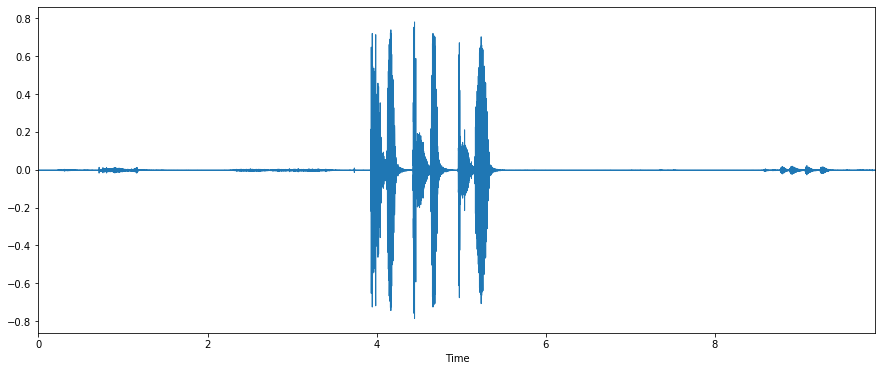

In [199]:
librosa.display.waveplot(ats[0], sr=sr);

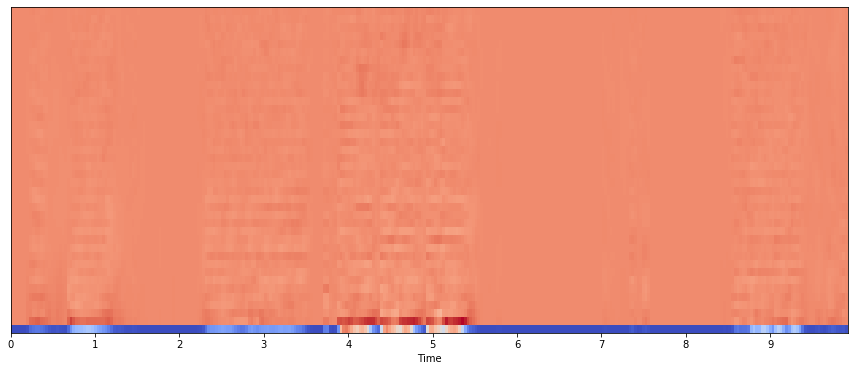

In [277]:
librosa.display.specshow(coughvid_mfcc[5], sr=SAMPLE_RATE, x_axis='time')

In [19]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mfcc.shape

(40, 191)

## Upsampling & Downsampling Train Set

In [ ]:
# upsampling & downsampling the training data only
df_coughvid_mfcc = pd.DataFrame({'mfcc_stats': coughvid_mfcc_train, 'label':y_coughvid_train}).reset_index(drop=True)
df_coughvid_majority = df_coughvid_mfcc[df_coughvid_mfcc['label'] == 0] # healthy
df_coughvid_minority = df_coughvid_mfcc[df_coughvid_mfcc['label'] == 1] # Covid-19

In [80]:
n_majority = len(df_coughvid_majority)
n_minority = len(df_coughvid_minority)

# upsampling
df_coughvid_mfcc_upsampled = pd.concat([df_coughvid_majority, 
                                       resample(df_coughvid_minority, 
                                                replace=True, 
                                                n_samples=n_majority, 
                                                random_state=RANDOM_SEED)])

# downsampling
df_coughvid_mfcc_downsampled = pd.concat([df_coughvid_minority, 
                                         resample(df_coughvid_majority, 
                                                  replace=False, 
                                                  n_samples=n_minority, 
                                                  random_state=RANDOM_SEED)])

In [86]:
# upsampled dataset
coughvid_mfcc_stats_upsampled = df_coughvid_mfcc_upsampled['mfcc_stats'].to_list()
y_coughvid_upsampled = df_coughvid_mfcc_upsampled['label'].to_list()

print('upsampled')
counter = Counter(y_coughvid_upsampled)
print(counter)
print(len(coughvid_mfcc_stats_upsampled))


# downsampled dataset
coughvid_mfcc_stats_downsampled = df_coughvid_mfcc_downsampled['mfcc_stats'].to_list()
y_coughvid_downsampled = df_coughvid_mfcc_downsampled['label'].to_list()

print('\ndownsampled')
counter = Counter(y_coughvid_downsampled)
print(counter)
print(len(coughvid_mfcc_stats_downsampled))


# SMOTE dataset
oversample = SMOTE()
coughvid_mfcc_stats_smote, y_coughvid_smote = oversample.fit_resample(coughvid_mfcc_train, y_coughvid_train)

print('\nsmote')
counter = Counter(y_coughvid_smote)
print(counter)
print(len(coughvid_mfcc_stats_smote))

upsampled
Counter({0: 4221, 1: 4221})
8442

downsampled
Counter({1: 404, 0: 404})
808

smote
Counter({0: 4221, 1: 4221})
8442


### saving numpy array

In [10]:
ats = np.load(COUGHVID_DATASET_PATH + 'audio_time_series.npy') 